In [14]:
import time
import random

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib_fontja
import seaborn as sns
import optuna
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors as Vectors
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## 70

In [15]:
gen: Vectors = KeyedVectors.load_word2vec_format('../7/GoogleNews-vectors-negative300.bin', binary=True)


In [16]:
with open('train.txt') as f:
  raw = [i.rstrip().split('\t') for i in f.readlines()]
  _, title_train, _, _, y_train, _, _, _ = zip(*raw)

with open('valid.txt') as f:
  raw = [i.rstrip().split('\t') for i in f.readlines()]
  _, title_valid, _, _, y_valid, _, _, _ = zip(*raw)

with open('test.txt') as f:
  raw = [i.rstrip().split('\t') for i in f.readlines()]
  _, title_test, _, _, y_test, _, _, _ = zip(*raw)

title = title_train + title_valid + title_test
y = y_train + y_valid + y_test
X = []

for t in title:
  t = t.split()
  vector = np.zeros(300)
  cnt = 0
  for w in t:
    try:
      v = gen.get_vector(w.replace("'", ''))
      vector += np.array(v)
      cnt += 1
    except:
      pass

  vector /= cnt
  X.append(vector)

category_map = {
  'b': 0,
  't': 1,
  'e': 2,
  'm': 3,
}

X = np.array(X)
y = np.array([category_map[i] for i in y]).astype(np.int64)

X_train, X_val_test = X[:len(title_train)], X[len(title_train):]
X_valid, X_test = X_val_test[:len(title_valid)], X_val_test[len(title_valid):]

y_train, y_val_test = y[:len(title_train)], y[len(title_train):]
y_valid, y_test = y_val_test[:len(title_valid)], y_val_test[len(title_valid):]

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).to(torch.int64)
X_valid = torch.Tensor(X_valid)
y_valid = torch.Tensor(y_valid).to(torch.int64)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).to(torch.int64)

np.savetxt('X_train.csv', X_train, delimiter=',')
np.savetxt('y_train.csv', y_train, fmt='%d', delimiter=',')
np.savetxt('X_valid.csv', X_valid, delimiter=',')
np.savetxt('y_valid.csv', y_valid, fmt='%d', delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_test.csv', y_test, fmt='%d', delimiter=',')


## 71

In [17]:
class NN(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc = nn.Linear(300, 4, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)

  def forward(self, x):
    x = self.fc(x)
    return x

model = NN()
y_0 = model(X_train[:1])
Y = model(X_train[:4])

print(torch.softmax(y_0, dim=-1))
print(torch.softmax(Y, dim=-1))


tensor([[0.6757, 0.0290, 0.2619, 0.0334]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6757, 0.0290, 0.2619, 0.0334],
        [0.6984, 0.0403, 0.0844, 0.1769],
        [0.6986, 0.0857, 0.2126, 0.0031],
        [0.6777, 0.2191, 0.0341, 0.0690]], grad_fn=<SoftmaxBackward0>)


## 72

In [18]:
loss_fn = nn.CrossEntropyLoss()

for i in [1, 4]:
  loss = loss_fn(model(X_train[:i]), y_train[:i])
  model.zero_grad()
  loss.backward()

  print(loss)
  print(model.fc.weight.grad)


tensor(1.3397, grad_fn=<NllLossBackward0>)
tensor([[ 3.8740e-02, -7.0620e-02, -7.8827e-02,  ..., -2.0277e-03,
          1.2484e-01, -5.6341e-03],
        [ 1.6617e-03, -3.0292e-03, -3.3813e-03,  ..., -8.6979e-05,
          5.3552e-03, -2.4167e-04],
        [-4.2316e-02,  7.7139e-02,  8.6104e-02,  ...,  2.2149e-03,
         -1.3637e-01,  6.1542e-03],
        [ 1.9146e-03, -3.4901e-03, -3.8957e-03,  ..., -1.0021e-04,
          6.1699e-03, -2.7844e-04]])
tensor(1.4800, grad_fn=<NllLossBackward0>)
tensor([[ 0.0322, -0.0074, -0.0114,  ..., -0.0036,  0.0550,  0.0087],
        [ 0.0052,  0.0025,  0.0026,  ..., -0.0017,  0.0089,  0.0021],
        [-0.0289,  0.0251,  0.0218,  ..., -0.0074, -0.0399,  0.0031],
        [-0.0085, -0.0202, -0.0130,  ...,  0.0127, -0.0241, -0.0139]])


## 73

In [19]:
class NewsDataset(Dataset):
  def __init__(self, X, y) -> None:
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return (self.X[idx], self.y[idx])


In [20]:

dataloader_train = DataLoader(NewsDataset(X_train, y_train), shuffle=True)
dataloader_valid = DataLoader(NewsDataset(X_valid, y_valid), batch_size=64)
dataloader_test = DataLoader(NewsDataset(X_test, y_test), batch_size=64)


In [21]:
model = NN()
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

for epoch in range(10):
  model.train()
  loss_train = 0
  for X, y in dataloader_train:
    optimizer.zero_grad()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    loss_train += loss.item()

  loss_train /= len(dataloader_train.dataset)

  model.eval()
  loss_valid = 0
  with torch.no_grad():
    for X, y in dataloader_valid:
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      loss_valid += loss.item()*X.size(0)

  loss_valid /= len(dataloader_valid.dataset)

  print(f"train: {loss_train:>7f}, valid: {loss_valid:>7f}")


train: 0.503456, valid: 0.371881
train: 0.339820, valid: 0.325818
train: 0.309114, valid: 0.313518
train: 0.292440, valid: 0.310658
train: 0.282636, valid: 0.307033
train: 0.274512, valid: 0.315146
train: 0.269562, valid: 0.309716
train: 0.266389, valid: 0.304929
train: 0.261891, valid: 0.307429
train: 0.259776, valid: 0.311240


## 74

In [22]:
for dataloader in [dataloader_train, dataloader_valid]:
  model.eval()
  correct = 0
  with torch.no_grad():
    for X, y in dataloader:
      y_pred = model(X)
      y_pred = y_pred.argmax(dim=1)
      correct += torch.sum(y_pred == y)

  print(correct.item() / len(dataloader.dataset))


0.9107076001497566
0.8944610778443114


## 75

In [23]:
model = NN()
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

losses_train = []
losses_valid = []
accuracy_train = []
accuracy_valid = []

for epoch in range(10):
  model.train()
  loss_train = 0
  for X, y in dataloader_train:
    optimizer.zero_grad()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    loss_train += loss.item()

  loss_train /= len(dataloader_train.dataset)
  losses_train.append(loss_train)

  model.eval()
  loss_valid = 0
  with torch.no_grad():
    correct = 0
    for X, y in dataloader_train:
      y_pred = model(X)
      y_pred = y_pred.argmax(dim=1)
      correct += torch.sum(y_pred == y).item()

    accuracy_train.append(correct / len(dataloader_train.dataset))
    correct = 0
    for X, y in dataloader_valid:
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      loss_valid += loss.item()*X.size(0)

      y_pred = y_pred.argmax(dim=1)
      correct += torch.sum(y_pred == y).item()

    accuracy_valid.append(correct / len(dataloader_valid.dataset))

  loss_valid /= len(dataloader_valid.dataset)
  losses_valid.append(loss_valid)

  print(f"train loss: {loss_train:>7f}, valid loss: {loss_valid:>7f}, train accuracy: {accuracy_train[-1]:>7f}, valid accuracy: {accuracy_valid[-1]:>7f}")


train loss: 0.495233, valid loss: 0.375075, train accuracy: 0.877574, valid accuracy: 0.864521
train loss: 0.335942, valid loss: 0.335893, train accuracy: 0.894422, valid accuracy: 0.879491
train loss: 0.305916, valid loss: 0.322581, train accuracy: 0.902377, valid accuracy: 0.884731
train loss: 0.291514, valid loss: 0.320984, train accuracy: 0.903501, valid accuracy: 0.887725
train loss: 0.281534, valid loss: 0.315840, train accuracy: 0.905092, valid accuracy: 0.886228
train loss: 0.273682, valid loss: 0.316431, train accuracy: 0.907712, valid accuracy: 0.890719
train loss: 0.269382, valid loss: 0.327541, train accuracy: 0.903407, valid accuracy: 0.887725
train loss: 0.265796, valid loss: 0.317946, train accuracy: 0.910240, valid accuracy: 0.885479
train loss: 0.262183, valid loss: 0.312456, train accuracy: 0.913422, valid accuracy: 0.889222
train loss: 0.258785, valid loss: 0.316832, train accuracy: 0.912860, valid accuracy: 0.891467


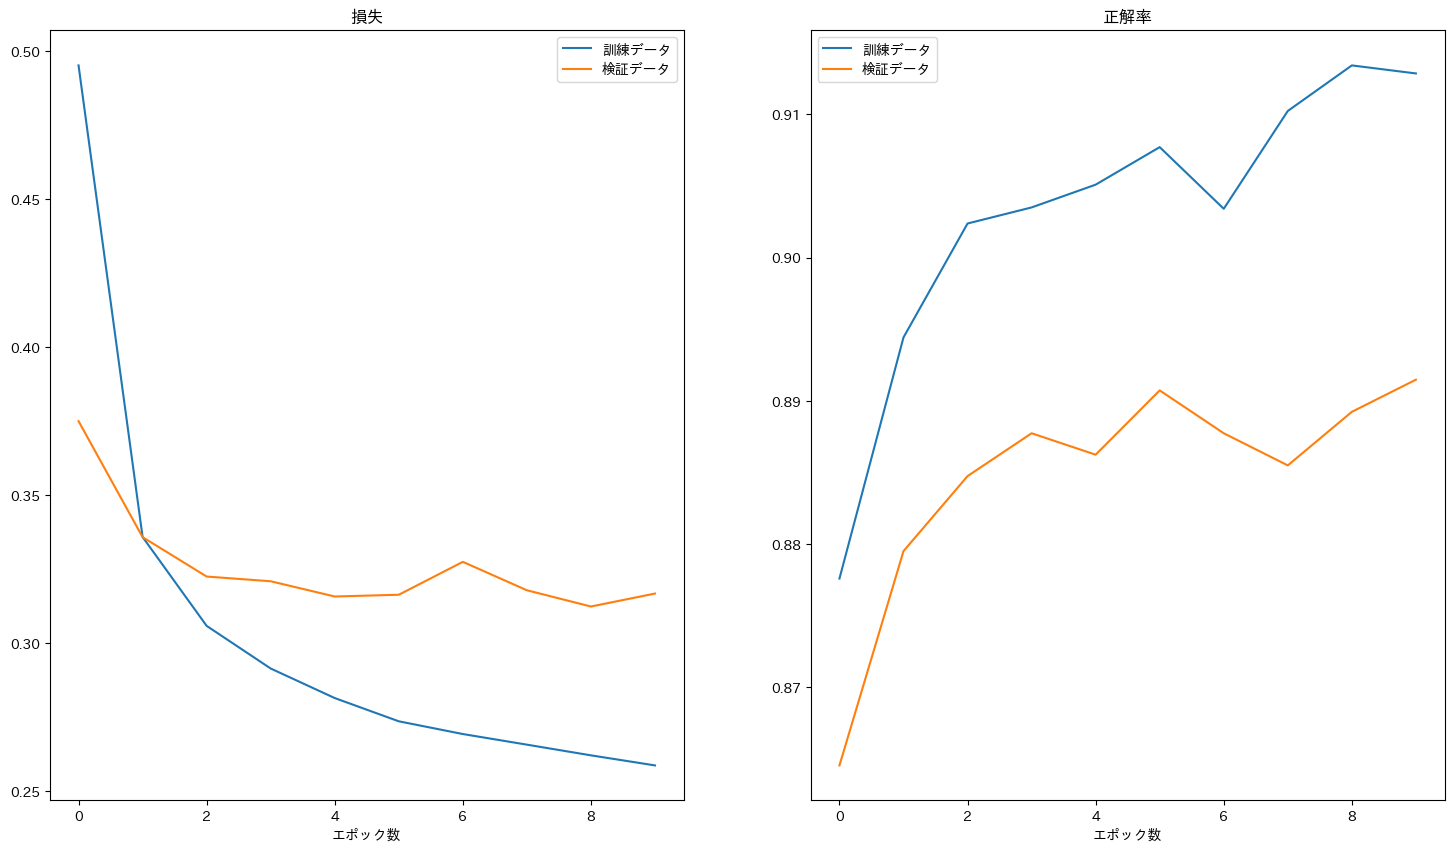

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax[0].plot(losses_train)
ax[0].plot(losses_valid)
ax[0].set_title('損失')
ax[0].set_xlabel('エポック数')
ax[0].legend(['訓練データ', '検証データ'])

ax[1].plot(accuracy_train)
ax[1].plot(accuracy_valid)
ax[1].set_title('正解率')
ax[1].set_xlabel('エポック数')
ax[1].legend(['訓練データ', '検証データ'])

plt.show()


## 76

In [25]:
model = NN()
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

losses_train = []
losses_valid = []
accuracy_train = []
accuracy_valid = []

for epoch in range(10):
  model.train()
  loss_train = 0
  for X, y in dataloader_train:
    optimizer.zero_grad()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    loss_train += loss.item()

  loss_train /= len(dataloader_train.dataset)
  losses_train.append(loss_train)

  model.eval()
  loss_valid = 0
  with torch.no_grad():
    correct = 0
    for X, y in dataloader_train:
      y_pred = model(X)
      y_pred = y_pred.argmax(dim=1)
      correct += torch.sum(y_pred == y).item()

    accuracy_train.append(correct / len(dataloader_train.dataset))
    correct = 0
    for X, y in dataloader_valid:
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      loss_valid += loss.item()*X.size(0)

      y_pred = y_pred.argmax(dim=1)
      correct += torch.sum(y_pred == y).item()

    accuracy_valid.append(correct / len(dataloader_valid.dataset))

  loss_valid /= len(dataloader_valid.dataset)
  losses_valid.append(loss_valid)
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'76/checkpoint{epoch + 1}.pt')

  print(f"train loss: {loss_train:>7f}, valid loss: {loss_valid:>7f}, train accuracy: {accuracy_train[-1]:>7f}, valid accuracy: {accuracy_valid[-1]:>7f}")


train loss: 0.503948, valid loss: 0.370973, train accuracy: 0.874485, valid accuracy: 0.874251
train loss: 0.346695, valid loss: 0.331027, train accuracy: 0.891894, valid accuracy: 0.883982
train loss: 0.314655, valid loss: 0.315381, train accuracy: 0.898446, valid accuracy: 0.887725
train loss: 0.297089, valid loss: 0.311139, train accuracy: 0.902565, valid accuracy: 0.885479
train loss: 0.285562, valid loss: 0.313809, train accuracy: 0.904343, valid accuracy: 0.892964
train loss: 0.278302, valid loss: 0.305769, train accuracy: 0.908180, valid accuracy: 0.894461
train loss: 0.271687, valid loss: 0.309126, train accuracy: 0.908461, valid accuracy: 0.890719
train loss: 0.267176, valid loss: 0.313200, train accuracy: 0.909772, valid accuracy: 0.890719
train loss: 0.264154, valid loss: 0.313472, train accuracy: 0.911176, valid accuracy: 0.892216
train loss: 0.260658, valid loss: 0.307426, train accuracy: 0.912673, valid accuracy: 0.896707


## 77

In [26]:
model = NN()
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

for B in [pow(2, i) for i in range(11)]:
  start = time.time()
  print(f'Batch size: {B}')
  dataloader_train = DataLoader(NewsDataset(X_train, y_train), batch_size=B, shuffle=True)
  for epoch in range(1):
    model.train()
    loss_train = 0
    for X, y in dataloader_train:
      optimizer.zero_grad()
      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()

      loss_train += loss.item()*X.size(0)

    loss_train /= len(dataloader_train.dataset)

    model.eval()
    loss_valid = 0
    with torch.no_grad():
      correct = 0
      for X, y in dataloader_train:
        y_pred = model(X)
        y_pred = y_pred.argmax(dim=1)
        correct += torch.sum(y_pred == y).item()

      correct = 0
      for X, y in dataloader_valid:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss_valid += loss.item()*X.size(0)

        y_pred = y_pred.argmax(dim=1)
        correct += torch.sum(y_pred == y).item()

    loss_valid /= len(dataloader_valid.dataset)

    print(f"train loss: {loss_train:>7f}, valid loss: {loss_valid:>7f}, train accuracy: {accuracy_train[-1]:>7f}, valid accuracy: {accuracy_valid[-1]:>7f}")

  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'77/checkpoint_{B}.pt')
  print(f'time elapsed: {time.time() - start}s')


Batch size: 1
train loss: 0.488771, valid loss: 0.364558, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 1.7617216110229492s
Batch size: 2
train loss: 0.339940, valid loss: 0.341340, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 1.1464574337005615s
Batch size: 4
train loss: 0.320177, valid loss: 0.331845, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.6873085498809814s
Batch size: 8
train loss: 0.312281, valid loss: 0.329581, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.39769840240478516s
Batch size: 16
train loss: 0.308628, valid loss: 0.327766, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.22942018508911133s
Batch size: 32
train loss: 0.306940, valid loss: 0.326917, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.12107014656066895s
Batch size: 64
train loss: 0.305970, valid loss: 0.326555, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.11403703689

## 78

In [27]:
model = NN().to('cuda')
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

dataloader_valid = DataLoader(NewsDataset(X_valid.to('cuda'), y_valid.to('cuda')), batch_size=64)
for B in [pow(2, i) for i in range(11)]:
  start = time.time()
  print(f'Batch size: {B}')
  dataloader_train = DataLoader(NewsDataset(X_train.to('cuda'), y_train.to('cuda')), batch_size=B, shuffle=True)
  for epoch in range(1):
    model.train()
    loss_train = 0
    for X, y in dataloader_train:
      optimizer.zero_grad()
      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()

      loss_train += loss.item()*X.size(0)

    loss_train /= len(dataloader_train.dataset)

    model.eval()
    loss_valid = 0
    with torch.no_grad():
      correct = 0
      for X, y in dataloader_train:
        y_pred = model(X)
        y_pred = y_pred.argmax(dim=1)
        correct += torch.sum(y_pred == y).item()

      correct = 0
      for X, y in dataloader_valid:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss_valid += loss.item()*X.size(0)

        y_pred = y_pred.argmax(dim=1)
        correct += torch.sum(y_pred == y).item()

    loss_valid /= len(dataloader_valid.dataset)

    print(f"train loss: {loss_train:>7f}, valid loss: {loss_valid:>7f}, train accuracy: {accuracy_train[-1]:>7f}, valid accuracy: {accuracy_valid[-1]:>7f}")

  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'78/checkpoint_{B}.pt')
  print(f'time elapsed: {time.time() - start}s')


Batch size: 1
train loss: 0.509284, valid loss: 0.366629, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 8.030008316040039s
Batch size: 2
train loss: 0.344836, valid loss: 0.338913, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 3.433979034423828s
Batch size: 4
train loss: 0.324242, valid loss: 0.332601, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 1.8511970043182373s
Batch size: 8
train loss: 0.315966, valid loss: 0.329521, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.9615130424499512s
Batch size: 16
train loss: 0.312069, valid loss: 0.327956, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.519174337387085s
Batch size: 32
train loss: 0.310117, valid loss: 0.328015, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.28693342208862305s
Batch size: 64
train loss: 0.309304, valid loss: 0.327316, train accuracy: 0.912673, valid accuracy: 0.896707
time elapsed: 0.1625964641571045

## 79

In [75]:
class NN(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc = nn.Sequential(
      nn.Linear(300, 200),
      nn.BatchNorm1d(200),
      nn.ReLU(),
      nn.Dropout(0.5),
      # nn.Linear(500, 500),
      # nn.BatchNorm1d(500),
      # nn.ReLU(),
      # nn.Dropout(0.3),
      nn.Linear(200, 4),
    )

  def forward(self, x):
    x = self.fc(x)
    return x


In [29]:
dataloader_train = DataLoader(NewsDataset(X_train.to('cuda'), y_train.to('cuda')), batch_size=64, shuffle=True)
dataloader_valid = DataLoader(NewsDataset(X_valid.to('cuda'), y_valid.to('cuda')), batch_size=64)
dataloader_test = DataLoader(NewsDataset(X_test.to('cuda'), y_test.to('cuda')), batch_size=64)


In [76]:
num_epochs = 300

model = NN().to('cuda')
optimizer = optim.AdamW(params=model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, 1e-5)

losses_train = []
losses_valid = []
accuracy_train = []
accuracy_valid = []

for epoch in range(num_epochs):
  model.train()
  loss_train = 0
  correct = 0
  for X, y in dataloader_train:
    optimizer.zero_grad()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    loss_train += loss.item()*X.size(0)

    y_pred = y_pred.argmax(dim=1)
    correct += torch.sum(y_pred == y).item()

  accuracy_train.append(correct / len(dataloader_train.dataset))
  loss_train /= len(dataloader_train.dataset)
  losses_train.append(loss_train)

  model.eval()
  loss_valid = 0
  with torch.no_grad():
    correct = 0
    for X, y in dataloader_valid:
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      loss_valid += loss.item()*X.size(0)

      y_pred = y_pred.argmax(dim=1)
      correct += torch.sum(y_pred == y).item()

    accuracy_valid.append(correct / len(dataloader_valid.dataset))
    loss_valid /= len(dataloader_valid.dataset)
    losses_valid.append(loss_valid)

  print(f"train loss: {loss_train:>7f}, valid loss: {loss_valid:>7f}, train accuracy: {accuracy_train[-1]:>7f}, valid accuracy: {accuracy_valid[-1]:>7f}")
  if epoch > 2 and losses_valid[epoch - 3] <= losses_valid[epoch - 2] <= losses_valid[epoch - 1] <= losses_valid[epoch]:
    break
  scheduler.step()


train loss: 0.428574, valid loss: 0.310555, train accuracy: 0.853519, valid accuracy: 0.893713
train loss: 0.312080, valid loss: 0.295166, train accuracy: 0.891614, valid accuracy: 0.898952
train loss: 0.275866, valid loss: 0.292322, train accuracy: 0.900786, valid accuracy: 0.897455
train loss: 0.247834, valid loss: 0.288979, train accuracy: 0.912580, valid accuracy: 0.898952
train loss: 0.231114, valid loss: 0.288924, train accuracy: 0.919880, valid accuracy: 0.904192
train loss: 0.211637, valid loss: 0.292296, train accuracy: 0.925122, valid accuracy: 0.901946
train loss: 0.198876, valid loss: 0.306811, train accuracy: 0.928678, valid accuracy: 0.895958
train loss: 0.186078, valid loss: 0.304258, train accuracy: 0.934201, valid accuracy: 0.897455
train loss: 0.172336, valid loss: 0.309241, train accuracy: 0.938319, valid accuracy: 0.898204
train loss: 0.166267, valid loss: 0.296454, train accuracy: 0.943280, valid accuracy: 0.908683
train loss: 0.153358, valid loss: 0.306562, train 

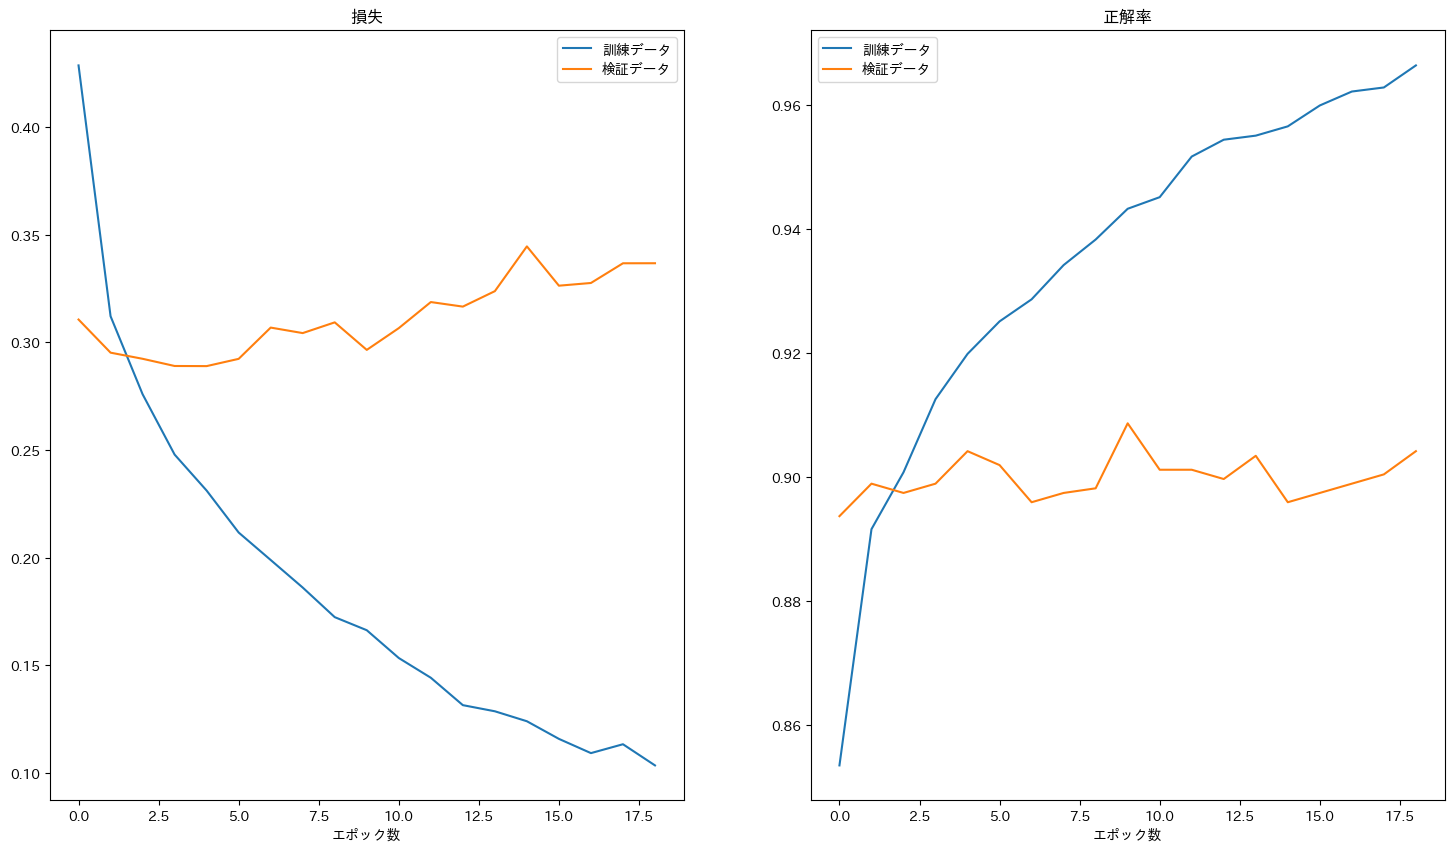

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax[0].plot(losses_train)
ax[0].plot(losses_valid)
ax[0].set_title('損失')
ax[0].set_xlabel('エポック数')
ax[0].legend(['訓練データ', '検証データ'])

ax[1].plot(accuracy_train)
ax[1].plot(accuracy_valid)
ax[1].set_title('正解率')
ax[1].set_xlabel('エポック数')
ax[1].legend(['訓練データ', '検証データ'])

plt.show()


## 71